In [1]:
#Imports
#Dataprep
import matplotlib.pyplot as plt
import numpy as np
from nilearn import datasets, plotting, image
from nilearn.maskers import NiftiMapsMasker
from sklearn.decomposition import FastICA
import pandas as pd
import tarfile
import gzip
#GNN required
import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch.nn as nn
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GraphConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import SubsetRandomSampler
from sklearn.metrics import accuracy_score

## Data Clean from HCP Data notebook

In [2]:
hcp_file = 'Data/netmats_3T_HCP1200_MSMAll_ICAd100_ts2.tar.gz'

In [3]:
# Read Network Matricies
data_raw = []

with gzip.open(hcp_file, 'rb') as gz_file:
    with tarfile.open(fileobj=gz_file, mode='r') as tar:
        
        # Extract a text file
        for file in tar.getnames():
            if file.endswith('.txt'):
                # Read the content and load it into a NumPy array
                subjects = np.loadtxt(tar.extractfile(file), dtype=float)
                
                ICAd = int(np.sqrt(subjects.shape[1]))
                
                # Convert into matrix
                matrix = np.array([np.reshape(i, (ICAd, ICAd)) for i in subjects])
                data_raw.append(matrix)
net_mat2 = data_raw[1]

In [52]:
id_file = 'Data/IDs/subjectIDs.txt'
id_recon1_file = 'Data/IDs/subjectIDs_recon1.txt'
id_recon2_file = 'Data/IDs/subjectIDs_recon2.txt'
subject_IDs = np.loadtxt(id_file, dtype=int)
subject_data = pd.read_csv('Data/subjects.csv', index_col = 'Subject')
subject_data = subject_data[['Gender', 'Age']]
net_mat_data = pd.Series(dict(zip(subject_IDs, net_mat2))).to_frame().rename(columns = {0 : 'netmat'})
data = subject_data.join(net_mat_data, how = 'right')

In [53]:
data

,Gender,Age,netmat
100206,M,26-30,"[[0.0, 0.61676, 9.5727, -5.4959, 0.34639, 3.00..."
100307,F,26-30,"[[0.0, -0.29664, 17.317, -9.0467, -0.28723, 1...."
100408,M,31-35,"[[0.0, 1.6486, 6.6189, -8.8877, 1.4337, 1.006,..."
100610,M,26-30,"[[0.0, -0.90275, 7.7215, -8.3907, 3.3144, 2.93..."
101006,F,31-35,"[[0.0, -0.088768, 9.4979, -10.412, 1.0646, 4.3..."
...,...,...,...
992673,F,31-35,"[[0.0, -0.11536, 7.1338, -5.5322, 0.34004, 1.6..."
992774,M,31-35,"[[0.0, 0.25353, 8.0265, -6.2072, 4.1589, 1.582..."
993675,F,26-30,"[[0.0, -1.0378, 10.709, -3.3224, -0.090704, 2...."
994273,M,26-30,"[[0.0, 0.64613, 11.471, -5.5137, 1.9357, 4.259..."


## Pytorch data preparing

In [6]:
def create_edge_index(num_nodes):
    num_edges = num_nodes * (num_nodes - 1) // 2
    source = []
    target = []
    for i in range(num_nodes):
        # iterate over all other nodes
        for j in range(i+1, num_nodes):
            source.append(i)
            target.append(j)

    edge_index = torch.tensor([source, target], dtype=torch.long)

    return edge_index

# Create an edge index for a fully connected graph with 100 nodes
edges = create_edge_index(100)
edges.size()

torch.Size([2, 4950])

In [7]:
import torch_geometric.utils as utils

In [8]:
netmats = data['netmat']

In [9]:
example = netmats.iloc[5]
mask = np.triu(abs(example) > 1, k=1)
edge_i = np.transpose(np.nonzero(mask))
t = torch.tensor(edge_i.T)
t.size()

torch.Size([2, 2467])

In [10]:
#Create an undirected edge index from a partial correlation matrix
def edge_gen_treshold(netmat, treshold):
    mask = np.triu(abs(netmat) > treshold, k=1) # using only bottom triangle 
    edge_i = np.transpose(np.nonzero(mask))
    return torch.tensor(edge_i.T)

In [11]:
ex_edges = edge_gen_treshold(example, 1)

In [12]:
import networkx as nx

C:\Users\terho\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\data\storage.py:449: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


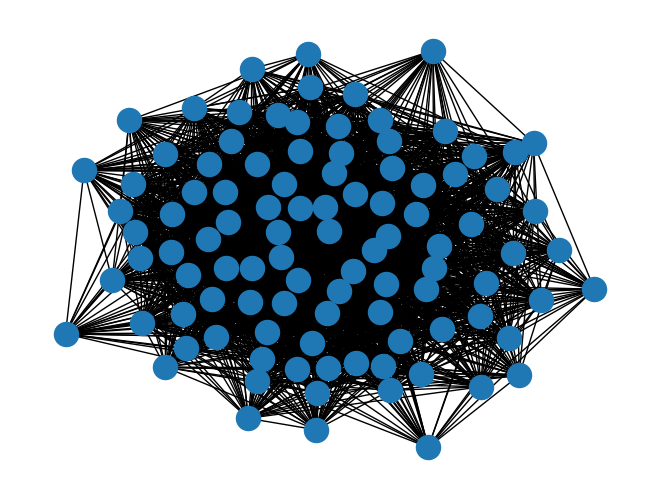

In [13]:
d = Data(x=None, edge_index=ex_edges)
g = torch_geometric.utils.to_networkx(d, to_undirected=True)
nx.draw(g)

In [14]:
edges

tensor([[ 0,  0,  0,  ..., 97, 97, 98],
        [ 1,  2,  3,  ..., 98, 99, 99]])

In [15]:
data['Gender'] = data['Gender'].replace({"M":0, "F":1})

In [16]:
data['Gender']

100206    0
100307    1
100408    0
100610    0
101006    1
         ..
992673    1
992774    0
993675    1
994273    0
996782    1
Name: Gender, Length: 1003, dtype: int64

In [17]:
labels = torch.tensor(data['Gender'].values)
labels

tensor([0, 1, 0,  ..., 1, 0, 1])

In [65]:
netmats = data['netmat']

def collate(data_list):
    graphs, labels = map(list, zip(*data_list))
    return {
        'graph': graphs,
        'label': labels
    }

# Custom dataset class
class CorrelationDataset(torch.utils.data.Dataset):
    def __init__(self, netmats, labels, edges, split_ratio=(0.8, 0.1, 0.1)):
        self.netmats = netmats
        self.labels = labels
        self.edges = edges
        self.split_ratios = split_ratio
        tot = len(self.netmats)
        train_samples = int(split_ratio[0] * tot)
        val_samples = int(split_ratio[1] * tot)
        
        # Splits
        self.train_indices = list(range(0, train_samples))  # 0 - train_samples
        self.val_indices = list(range(train_samples, train_samples + val_samples))
        self.test_indices = list(range(train_samples + val_samples, tot))
        
    def __len__(self):
        return len(self.netmats)

    def __getitem__(self, idx):
        nmap = torch.tensor(self.netmats.iloc[idx]).float()
        edge_index = edge_gen_treshold(nmap, 1)
        graph_data = Data(x=nmap, edge_index=edge_index)
        label = self.labels[idx]
        return graph_data, label
    
    def get_split(self, idx):
        if idx in self.train_indices:
            return 'train'
        elif idx in self.val_indices:
            return 'val'
        elif idx in self.test_indices:
            return 'test'
        else:
            raise ValueError('Index not in any split')

# Create the custom dataset
collate_fn = collate
dataset = CorrelationDataset(netmats, labels, edges, split_ratio=(0.8, 0.1, 0.1))
train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SubsetRandomSampler(dataset.train_indices), collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SubsetRandomSampler(dataset.val_indices), collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SubsetRandomSampler(dataset.test_indices), collate_fn=collate_fn)

In [66]:
test = iter(train_loader)
print(next(test))

{'graph': [Data(x=[100, 100], edge_index=[2, 2880])], 'label': [tensor(0)]}


In [67]:
class GCN(nn.Module):
    def __init__(self,):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(100, 300)
        self.conv2 = GCNConv(300, 250)
        self.conv3 = GCNConv(250, 100)
        self.classifier = Linear(100, 1)

    def forward(self, data):
        data = data['graph'][0]
        x, edge_index = data.x, data.edge_index
        x = nn.Tanh()(self.conv1(x, edge_index))
        x = nn.Dropout(p=0.7)(x)
        x = nn.Tanh()(self.conv2(x, edge_index))
        x = nn.Dropout(p=0.7)(x)
        x = F.relu(self.conv3(x, edge_index))
        x = nn.Dropout(p=0.7)(x)
        x = self.classifier(x).mean(dim=0)
        x = torch.sigmoid(x)
        return torch.round(x)
    

In [68]:
model = GCN()
print(model)

GCN(
  (conv1): GCNConv(100, 300)
  (conv2): GCNConv(300, 250)
  (conv3): GCNConv(250, 100)
  (classifier): Linear(in_features=100, out_features=1, bias=True)
)


In [69]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [70]:
test = iter(train_loader)
print(next(test))

{'graph': [Data(x=[100, 100], edge_index=[2, 2739])], 'label': [tensor(1)]}


In [71]:
model(next(test))

tensor([0.], grad_fn=<RoundBackward0>)

In [72]:
criterion(torch.tensor([1]).double(),torch.tensor([0]).double())

tensor(100., dtype=torch.float64)

In [73]:
def train(model, data_loader, device, loss_fn, optimizer):
    model.train()
    total_loss = 0
    num_true = 0
    num_true_guesses = 0
    for d in data_loader:
        m = d['graph'][0]
        m = m.to(device)
        label = d['label'][0]
        optimizer.zero_grad()
        out = model(d).squeeze()
        loss = loss_fn(out.double(), label.double())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if out.double() == label.double():
            num_true += 1
        if out.double() == 1:
            num_true_guesses += 1
    return total_loss, num_true, num_true_guesses

def eval(model, loader, device):
    model.eval()
    cor = 0
    tot = 0
    for d in loader:
        with torch.no_grad():
            pred = model(d)
        y = d['label'][0]
        cor += (pred == y).sum()
        tot += pred.shape[0]
    return cor/tot
        

Epoch: 1/20, Loss: 37200.0, Avg Loss: 46.384, Train: 53.99%, Validation: 44.00%, Num Correct: 430, True Guesses: 714 
Epoch: 2/20, Loss: 35800.0, Avg Loss: 44.638, Train: 54.49%, Validation: 51.00%, Num Correct: 444, True Guesses: 714 
Epoch: 3/20, Loss: 36100.0, Avg Loss: 45.012, Train: 52.87%, Validation: 45.00%, Num Correct: 441, True Guesses: 715 
Epoch: 4/20, Loss: 36900.0, Avg Loss: 46.010, Train: 54.61%, Validation: 49.00%, Num Correct: 433, True Guesses: 717 
Epoch: 5/20, Loss: 37800.0, Avg Loss: 47.132, Train: 52.49%, Validation: 49.00%, Num Correct: 424, True Guesses: 712 
Epoch: 6/20, Loss: 38300.0, Avg Loss: 47.756, Train: 54.74%, Validation: 48.00%, Num Correct: 419, True Guesses: 721 
Epoch: 7/20, Loss: 38400.0, Avg Loss: 47.880, Train: 53.87%, Validation: 53.00%, Num Correct: 418, True Guesses: 728 
Epoch: 8/20, Loss: 37200.0, Avg Loss: 46.384, Train: 53.12%, Validation: 46.00%, Num Correct: 430, True Guesses: 736 
Epoch: 9/20, Loss: 37300.0, Avg Loss: 46.509, Train: 53.

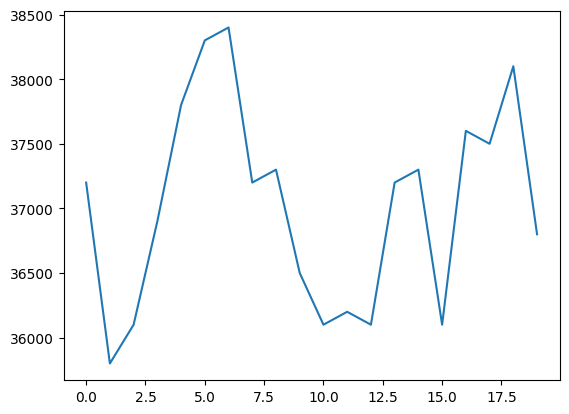

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GCN().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()
losses = []

num_epochs = 20
for epoch in range(num_epochs):
    loss, num_true, num_true_guesses = train(model, train_loader, device, criterion, optimizer)
    train_results = eval(model, train_loader, device)
    val_results = eval(model, val_loader, device)
    losses.append(loss)
    avg_loss = loss / len(train_loader)
    print(f'Epoch: {epoch + 1}/{num_epochs}, '
          f'Loss: {loss}, '
          f'Avg Loss: {avg_loss:.3f}, '
          f'Train: {100 * train_results:.2f}%, '
          f'Validation: {100 * val_results:.2f}%, '
          f'Num Correct: {num_true}, '
          f'True Guesses: {num_true_guesses} ')
    
    
plt.plot(losses)
plt.show()

In [49]:
"""
#old approach 
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    num_true = 0
    num_true_guesses = 0
    for data in train_loader:
        m = data['graph'][0]
        label = data['label'][0]
        optimizer.zero_grad()
        out = model(data).squeeze()
        loss = criterion(out.double(), label.double())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if out.double() == label.double():
            num_true += 1
        if out.double() == 1:
            num_true_guesses += 1
            
    accuracy = 100 * num_true / len(train_loader)
    average_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.8f}, Training Accuracy: {accuracy:.8f}%, num_true: {num_true}, true_guesses: {num_true_guesses}')
"""

"\n#old approach \nnum_epochs = 3\nfor epoch in range(num_epochs):\n    model.train()\n    total_loss = 0\n    num_true = 0\n    num_true_guesses = 0\n    for data in train_loader:\n        m = data['graph'][0]\n        label = data['label'][0]\n        optimizer.zero_grad()\n        out = model(data).squeeze()\n        loss = criterion(out.double(), label.double())\n        loss.backward()\n        optimizer.step()\n        total_loss += loss.item()\n        if out.double() == label.double():\n            num_true += 1\n        if out.double() == 1:\n            num_true_guesses += 1\n            \n    accuracy = 100 * num_true / len(train_loader)\n    average_loss = total_loss / len(train_loader)\n    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.8f}, Training Accuracy: {accuracy:.8f}%, num_true: {num_true}, true_guesses: {num_true_guesses}')\n"

In [46]:
for parameter in model.parameters():
    print(len(parameter))

300
300
250
250
100
100
1
1


In [47]:
i = 0
for parameter in model.parameters():
    if i == 1:
        matrix = parameter.data.numpy()
    i += 1

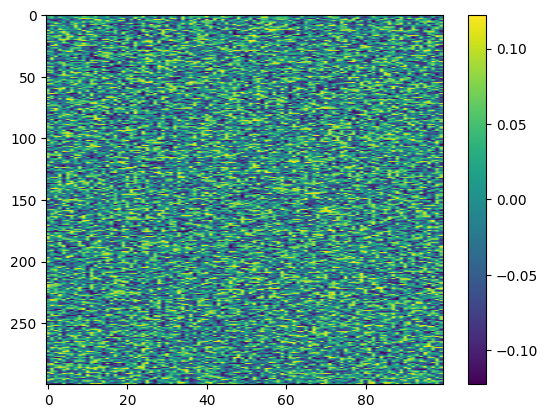

In [48]:
plt.imshow(matrix, aspect='auto')
plt.colorbar()